/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


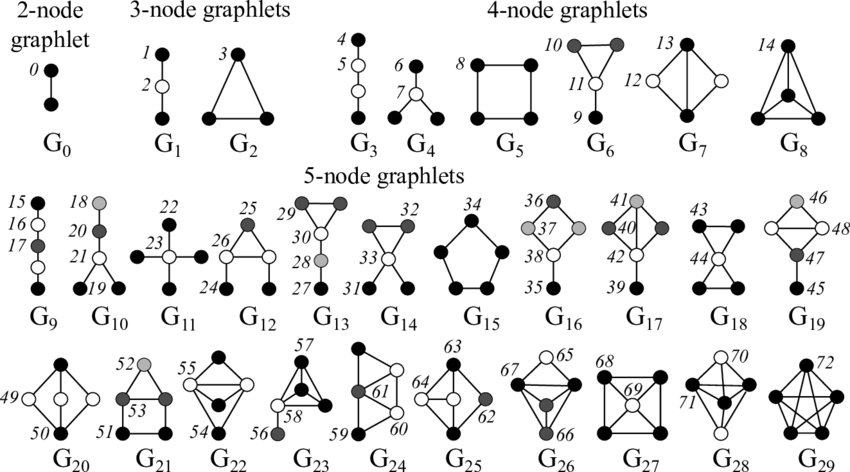

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tool as gt
import pandas as pd                                #manipulate arrays

import csv
import time 
from tqdm import tqdm
from IPython import display                        #handy for code reading

import graph_tool.clustering as gtc 
import graph_tool.generation as gtg
import graph_tool.draw as gtd                      #manipulate graphs

from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering #unsupervised learning

#path to output plots, stats of this code

output = '/Users/endingalaporte/Desktop/graphlet_kernel/output/'

#import graphs and labels
    
def string_to_list(string):
    """given a string of two elements, returns each element in a list"""
    return [int(string.split(' ')[0]), int(string.split(' ')[1])]

#import n cities
n = 136
G_list = np.array([gt.Graph(directed = False) for i in range(n)], dtype = object)
o_f = '/Users/endingalaporte/Desktop/graphlet_kernel/input'
for i in range(n):
    open_path = o_f + "/edgelist_city"+str(i)+".txt"
    #print(open_path)
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    G_list[i].add_edge_list(elist)

#import labels
label_path = '/Users/endingalaporte/Desktop/graphlet_kernel/input/country_binary.txt'
text = open(label_path, encoding='utf-16')
reader = csv.reader(text, delimiter='\n')
labels = np.array([int(row[0]) for row in reader])
labels = labels[0:len(G_list)]


names = np.arange(n)
"""
#import 100 names of city
names_path = '/Users/endingalaporte/Desktop/graphlet_kernel/input/communes.txt'
text = open(names_path, 'r')
reader = csv.reader(text, delimiter='\n')
names = np.array([row[0] for row in reader])
names = names[0:len(G_list)]
"""

#import 29 graphlets
m = 29
graphlets = np.array([gt.Graph(directed = False) for i in range(m)], dtype = object)
o_f = '/Users/endingalaporte/Desktop/graphlet_kernel/src/graphlets'
for i in range(m):
    open_path = o_f + "/g"+str(i+1)+"_edgelist.txt"
    text = open(open_path, 'r')
    reader = csv.reader(text, delimiter='\n')
    elist = [string_to_list(row[0]) for row in reader]
    graphlets[i].add_edge_list(elist)
    
graphlets3 = graphlets[0:2] #3-graphlets
graphlets4 = graphlets[2:8] #4-graphlets
graphlets5 = graphlets[8:29] #5-graphlets

#phi transform a graph to a size 29 vector of 345graphlet counts
def phi_345graphlet(G : gt.Graph):
    """given graph G, returns the graphlet count vector for all 29 3,4,5-graphlets"""
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    return counts345

def phi_345graphlet_normalized(G : gt.Graph):
    """
    given graph G, returns the normalized
    graphlet count vector for all connected 3,4,5-graphlets
    """
    _, counts3 = gtc.motifs(G, p = 1.0, motif_list = graphlets3, k = 3)
    _, counts4 = gtc.motifs(G, p = 1.0, motif_list = graphlets4, k = 4)
    _, counts5 = gtc.motifs(G, p = 1.0, motif_list = graphlets5, k = 5)
    counts345 = np.concatenate((counts3,counts4,counts5), axis = 0)
    counts345 = counts345/counts345.sum()
    return counts345

display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/graphlets.png")

In [2]:
len(G_list), len(labels)

(136, 136)

In [3]:
noeuds = []
for g in G_list:
    noeuds.append(len(tuple(g.vertices())))
    
noeuds = np.array(noeuds)
noeuds.mean(), noeuds.std()

(16230.963235294117, 22910.413363285035)

In [4]:
noeuds.min(), noeuds.max()

(509, 127641)

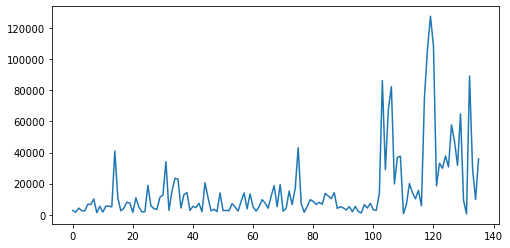

In [5]:
plt.figure(figsize = (8,4))
plt.plot(noeuds)

{'whiskers': [<matplotlib.lines.Line2D at 0x15dcbc820>,
 'caps': [<matplotlib.lines.Line2D at 0x15dcbcee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x15dcbc4c0>],
 'medians': [<matplotlib.lines.Line2D at 0x15dc855e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x15dc858e0>],
 'means': []}

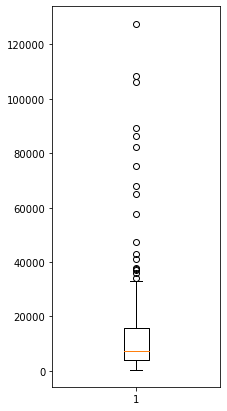

In [6]:
plt.figure(figsize = (3,7))
plt.boxplot(noeuds)

In [7]:
#Here, we choose to execute one of the following three choice, the kernel 1,2 or n°3

s = time.time()
choice = 2

if choice == 1:    
    #fill matrix of all_phi (vector of counts not normalized)
    all_phi_not_centered_not_normalized = np.zeros([n,len(graphlets)])

    for i,g in tqdm(enumerate(G_list)):
        all_phi_not_centered_not_normalized[i] = phi_345graphlet(g)
    all_phi = all_phi_not_centered_not_normalized
if choice == 2:
    #fill matrix of all_phi (normalized vector of counts)
    all_phi_not_centered = np.zeros([n,len(graphlets)])
    for i,g in tqdm(enumerate(G_list)):
        all_phi_not_centered[i] = phi_345graphlet_normalized(g)
    all_phi = all_phi_not_centered
if choice == 3:
    #fill matrix of all_phi (normalized vector of counts)
    #then center and reduce each column graphlet count accross all cities

    all_phi = np.zeros([n,len(graphlets)])

    for i,g in tqdm(enumerate(G_list)):
        all_phi[i] = phi_345graphlet_normalized(g) #fill all_phi for each i-th city

    for j in range(all_phi.shape[1]):
        if all_phi[:,j].std() != 0:
            all_phi[:,j] = (all_phi[:,j]-all_phi[:,j].mean())/all_phi[:,j].std() #center reduce all_phi for each j-th graphlet
            
print("duration", time.time()-s)

136it [16:21,  7.21s/it]

duration 981.0394818782806


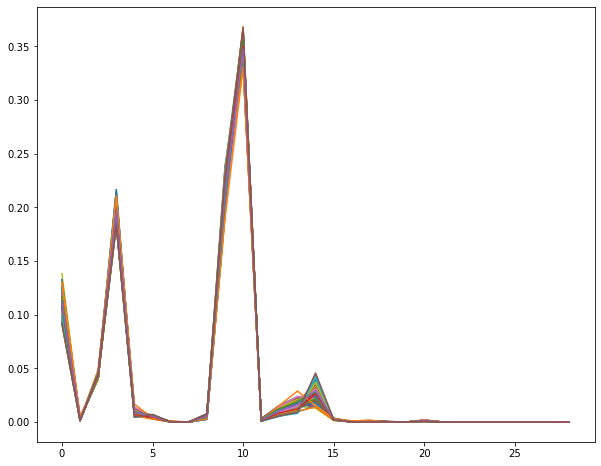

In [8]:
#visualize the phi vector of each city
plt.figure(figsize = (10,8))
for i in range(len(all_phi)):
    plt.plot(all_phi[i])
plt.savefig(output+"all_phi_normalized_centered_reduced_136cities.svg")

No handles with labels found to put in legend.


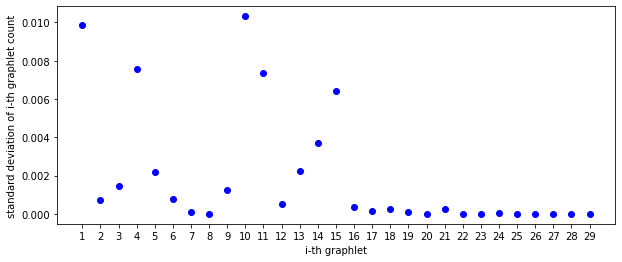

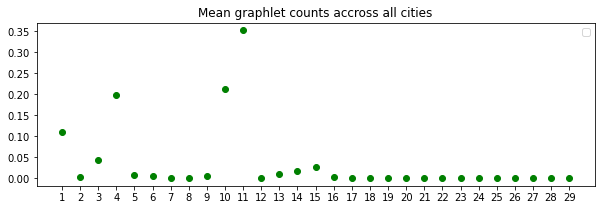

In [9]:
#standard deviation and mean of all phi vectors
std = []
mean = []
for i in range(len(all_phi[0])):
    std.append(all_phi[:,i].std())
    mean.append(all_phi[:,i].mean())

plt.figure(figsize=(10, 4))
plt.xlabel("i-th graphlet")
plt.ylabel("standard deviation of i-th graphlet count")
#plt.title("Standard deviation of graphlet count accross all cities")
plt.scatter(np.arange(1, len(std)+1),std, c = 'b')
plt.xticks(np.arange(1, 30, 1))
plt.savefig("/Users/endingalaporte/Desktop/graphlet_kernel/output/std_counts.svg", dpi = 200)

plt.figure(figsize=(10, 3))
plt.title("Mean graphlet counts accross all cities")
plt.scatter(np.arange(1, len(mean)+1),mean, c = 'g')
plt.xticks(np.arange(1, 30, 1))
plt.legend()

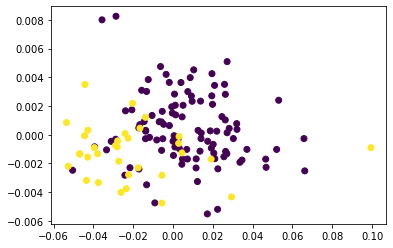

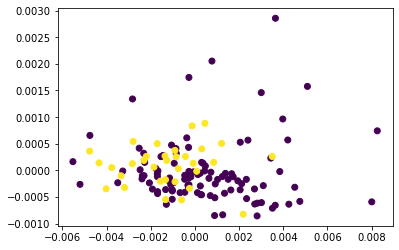

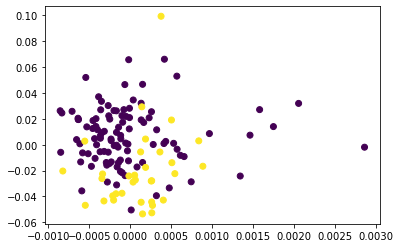

In [10]:
#kernel matrix K
K = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        K[i,j] = np.dot(all_phi[i], all_phi[j])
        
#PCA using kernel matrix K

reducer = PCA(n_components = 3)
embed = reducer.fit_transform(K)
plt.scatter(embed[:,0], embed[:,1], c = labels, marker = "o")
plt.savefig(output + '12dim_pca_345graphlet_normalized_kernel'+str(n)+'cities.svg')
plt.subplots()
plt.scatter(embed[:,1], embed[:,2], c = labels, marker = "o")
plt.savefig(output + '23dim_pca_345graphlet_normalized_kernel'+str(n)+'cities.svg')
plt.subplots()
plt.scatter(embed[:,2], embed[:,0], c = labels, marker = "o")
plt.savefig(output + '30dim_pca_345graphlet_normalized_kernel'+str(n)+'cities.svg')

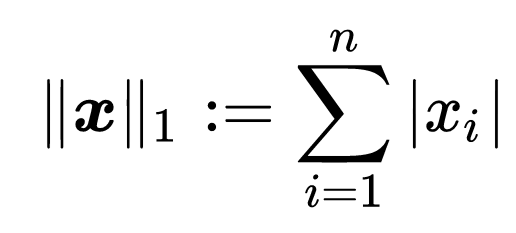

In [11]:
display.Image("/Users/endingalaporte/Desktop/graphlet_kernel/src/image/l1_manhattan_norm.png")

/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


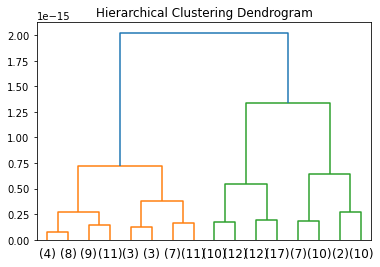

In [12]:
#distance matrix D
D = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        D[i,j] = abs((all_phi[i]-all_phi[j]).sum()) #l1 Manhattan norm

#dendogram from distance matrix D

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(D)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.show()

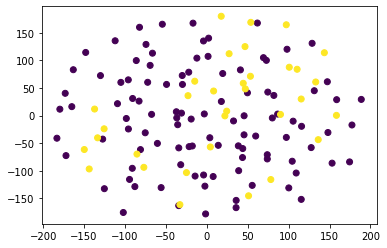

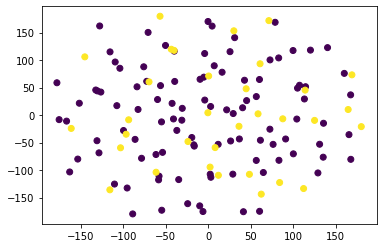

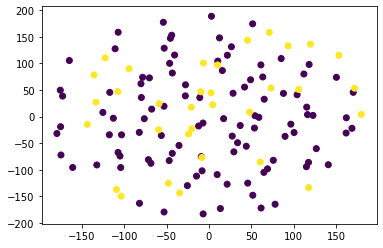

In [13]:
#TSNE from distance matrix D
model = TSNE(n_components = 3)
model.fit(D)
ed = model.fit_transform(D)
plt.scatter(ed[:,0], ed[:,1], c = labels)
plt.subplots()
plt.scatter(ed[:,1], ed[:,2], c = labels)
plt.subplots()
plt.scatter(ed[:,2], ed[:,0], c = labels)

In [14]:
#save graphlet counts of each city to .csv

n_edges_vertices = []
for i in range(n):
    n_edges_vertices.append([len(tuple(G_list[i].edges())), len(tuple(G_list[i].vertices()))])

n_edges_vertices = np.array(n_edges_vertices)
names = np.array(names)
names = names.reshape(n,1)
labels = labels.reshape(n,1)
numpy_data = np.concatenate((names, n_edges_vertices, labels, all_phi),axis = 1)

In [15]:
df = pd.DataFrame(data=numpy_data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0.0,3454.0,2744.0,0.0,0.132779,0.003887,0.043205,0.213291,0.011683,0.004180,...,0.0,0.001152,0.000000,0.0,0.000045,0.00000,0.0,0.0,0.0,0.0
1,1.0,2187.0,1662.0,0.0,0.119687,0.003062,0.042351,0.205087,0.010247,0.004365,...,0.0,0.000879,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
2,2.0,6000.0,4240.0,0.0,0.110803,0.003099,0.041484,0.198266,0.011338,0.005477,...,0.0,0.001463,0.000019,0.0,0.000019,0.00001,0.0,0.0,0.0,0.0
3,3.0,3510.0,2590.0,0.0,0.121996,0.003918,0.040174,0.207891,0.013191,0.004132,...,0.0,0.000931,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0
4,4.0,3257.0,2474.0,0.0,0.119121,0.002534,0.042986,0.205837,0.008730,0.004144,...,0.0,0.000966,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0


In [16]:
df = pd.DataFrame(data=numpy_data
                  ,columns=["city_name", "n_edges","n_vertices","is_chinese_city_or_not","n_g1","n_g2","n_g3","n_g4","n_g5","n_g6","n_g7","n_g8","n_g9","n_g10","n_g11","n_g12","n_g13","n_g14","n_g15","n_g16","n_g17","n_g18","n_g19","n_g20","n_g21","n_g22", "n_g23", "n_g24", "n_g25", "n_g26", "n_g27", "n_g28", "n_g29"])
output_cities_stats = output+"/city_stats_normalized_standardized"+str(n)+"cities.csv"
df.to_csv(output_cities_stats)

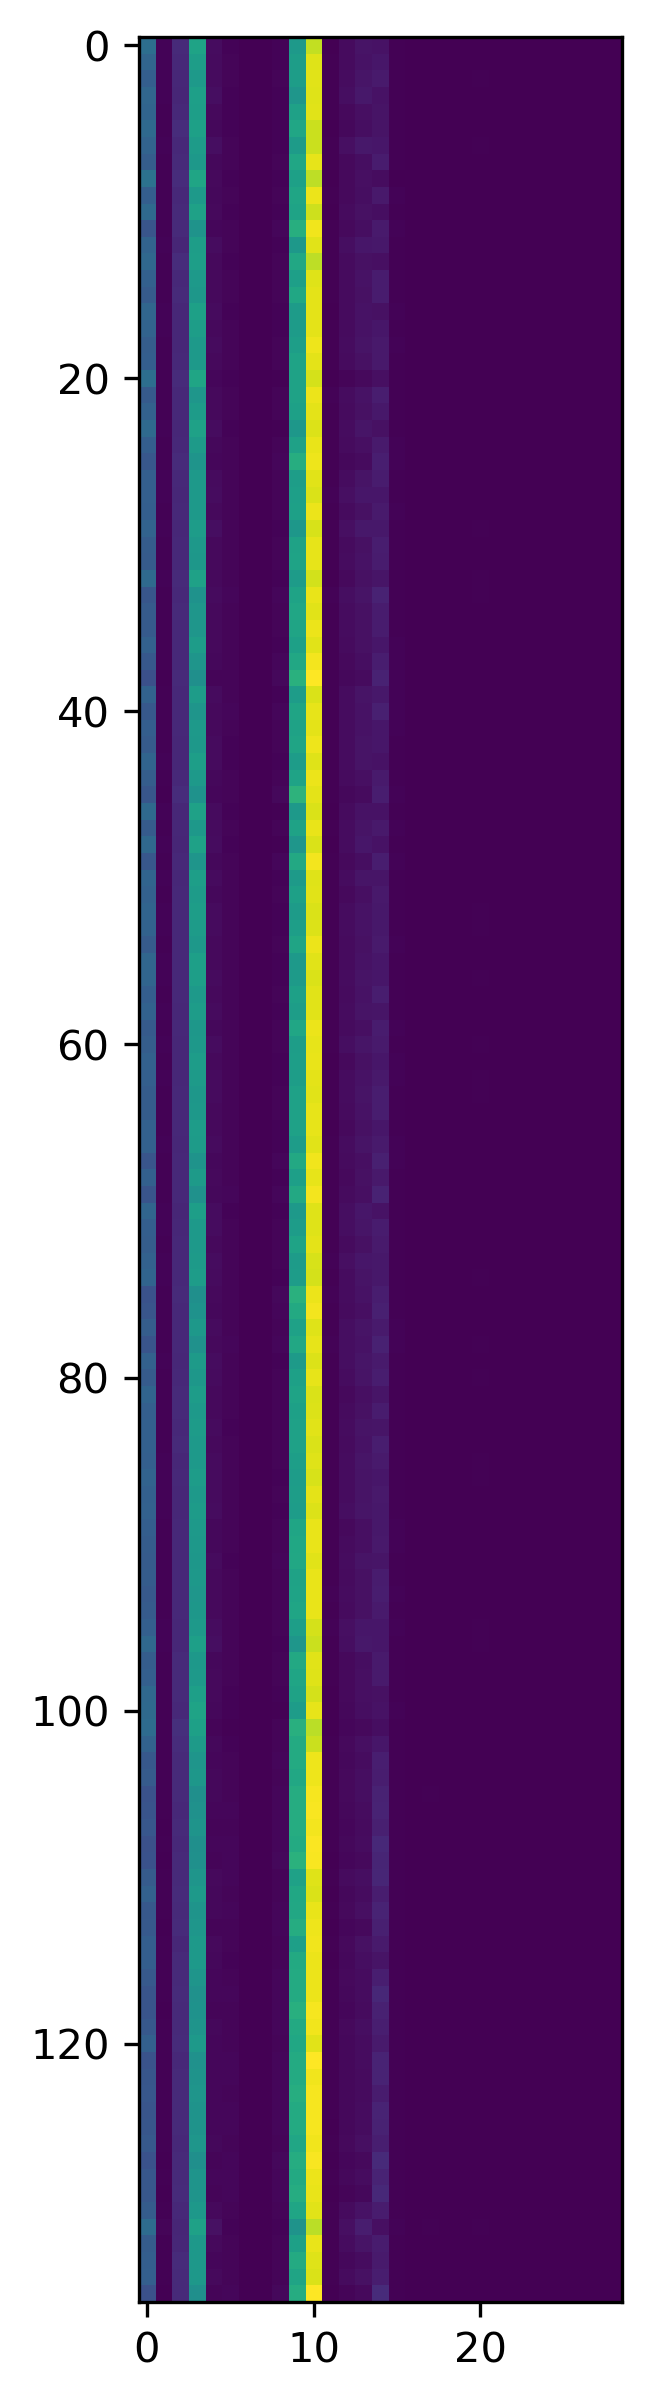

In [17]:
import pandas as pd

df = pd.read_csv(output_cities_stats)
plt.figure(figsize = (10,10), dpi = 300)
plt.imshow(df[['n_g1', 'n_g2', 'n_g3', 'n_g4', 'n_g5',
       'n_g6', 'n_g7', 'n_g8', 'n_g9', 'n_g10', 'n_g11', 'n_g12', 'n_g13',
       'n_g14', 'n_g15', 'n_g16', 'n_g17', 'n_g18', 'n_g19', 'n_g20', 'n_g21',
       'n_g22', 'n_g23', 'n_g24', 'n_g25', 'n_g26', 'n_g27', 'n_g28', 'n_g29']].to_numpy())

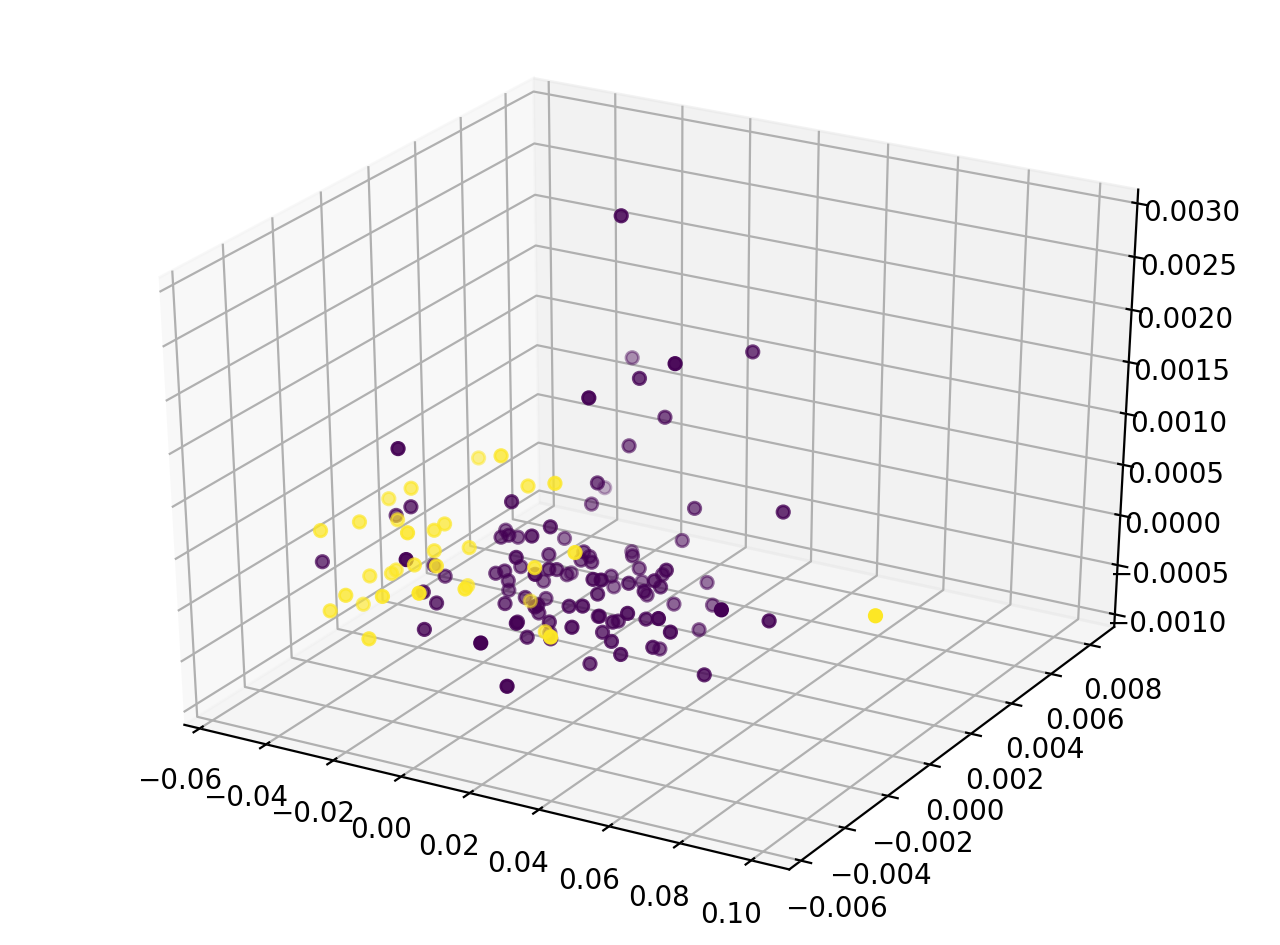

In [18]:
#3D plots of three components of PCA


from mpl_toolkits import mplot3d

import numpy as np

x, y, z = embed[:,0], embed[:,1], embed[:,2]

fig = plt.figure(figsize = (8,6), dpi = 200)
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = z
xline = x
yline = y
ax.scatter(xline, yline, zline, c = labels)
plt.savefig(output + '3components3D_pca_345graphlet_normalized_kernel'+str(n)+'cities.svg')

In [19]:
#evaluate cluster quality

from sklearn.metrics import silhouette_score

silhouette_score(embed, labels), silhouette_score(all_phi, labels)

/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


(0.2673125843380763, 0.23849402978368092)

In [20]:
silhouette_score(all_phi, labels, metric = "l1")

/Users/endingalaporte/Documents/python/miniconda3/envs/jupyternotebookenv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.26593441243095617

In [21]:
print("time to run the kernel is", 956.700651884079/60, "mins")

time to run the kernel is 15.94501086473465 mins
